# Install libraries required

In [ ]:
!pip install transformers hdbscan pacmap

# Download dataset

In [ ]:
!wget https://s3-us-west-2.amazonaws.com/ai2-website/data/ARC-V1-Feb2018.zip

In [ ]:
from zipfile import ZipFile

with ZipFile('ARC-V1-Feb2018.zip', "r") as zip_obj:
    zip_obj.extractall("data")    

# Import dataset into Pandas

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data/ARC-V1-Feb2018-2/ARC-Easy/ARC-Easy-Train.csv")

# Load transformer model

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from itertools import zip_longest
import torch


def grouper(iterable, n, fillvalue=None):
    """Taken from: https://docs.python.org/3/library/itertools.html#itertools-recipes"""
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)


def mean_pooling(model_output, attention_mask):
    """
    Mean pooling to get sentence embeddings. See:
    https://huggingface.co/sentence-transformers/paraphrase-distilroberta-base-v1
    """
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) # Sum columns
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Sentences to embed
df = df[df.question.str.contains('\?')]
df.question = [s.split('?')[0] + '?' for s in df.question]

# Fetch the model & tokenizer from transformers library
model_name = 'sentence-transformers/stsb-roberta-large'
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create sentence embeddings

In [ ]:
sentence_embeddings = []
token_embeddings = []

# Embed 8 sentences at a time
for sentences in tqdm(grouper(df.question.tolist(), 8, None)):
    
    # Ignore sentences with None
    valid_sentences = [s for s in sentences if s]

    # Tokenize input
    encoded_input = tokenizer(valid_sentences, padding=True, truncation=True, max_length=512, return_tensors="pt")    

    # Create word embeddings
    model_output = model(**encoded_input)

    # For each sentence, store a list of token embeddings; i.e. a 1024-dimensional vector for each token
    for i, sentence in enumerate(valid_sentences):
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][i])
        embeddings = model_output[0][i]
        token_embeddings.append(
            [{"token": token, "embedding": embedding.detach().numpy()} for token, embedding in zip(tokens, embeddings)]
        )    

    # Pool to get sentence embeddings; i.e. generate one 1024 vector for the entire sentence
    sentence_embeddings.append(
        mean_pooling(model_output, encoded_input['attention_mask']).detach().numpy()
    )
    
# Concatenate all of the embeddings into one numpy array of shape (n_sentences, 1024)
sentence_embeddings = np.concatenate(sentence_embeddings)

223it [09:57,  2.68s/it]


# Perform Search & Show Search Context

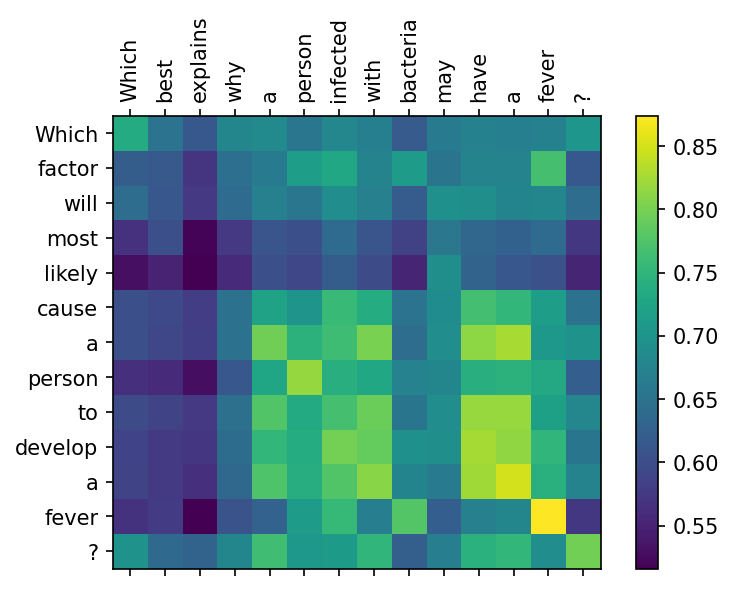

In [ ]:
from IPython.core.display import display, HTML
from sklearn.preprocessing import normalize
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Noralize the data
norm_data = normalize(sentence_embeddings, norm='l2')

# Set QUERY & BEST MATCH IDs
QUERY_ID = 0
scores = np.dot(norm_data, norm_data[QUERY_ID].T)
MATCH_ID = np.argsort(scores)[-2]


def get_token_embeddings(embeddings_word):
    """Returns a list of tokens and list of embeddings"""
    tokens, embeddings = [], []
    for word in embeddings_word:
        if word['token'] not in ['<s>', '<pad>', '</pad>', '</s>']:
            tokens.append(word['token'].replace('Ġ', ''))
            embeddings.append(word['embedding'])    
    return tokens, normalize(embeddings, norm='l2')

# Get tokens & token embeddings
query_tokens, query_token_embeddings = get_token_embeddings(token_embeddings[QUERY_ID])
match_tokens, match_token_embeddings = get_token_embeddings(token_embeddings[MATCH_ID])

# Calculate cosine similarity between all tokens in query and match sentences
attention = (query_token_embeddings @ match_token_embeddings.T)

def plot_attention(src, trg, attention):
    """Plot 2D plot of cosine similarities"""
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attention, interpolation='nearest')
    clb = fig.colorbar(cax)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + src, rotation=90)
    ax.set_yticklabels([''] + trg) 
    

plot_attention(match_tokens, query_tokens, attention)

In [ ]:
lengths_query

array([31.789795, 31.70999 , 31.7887  , 31.811132, 31.831669, 31.8176  ,
       31.872398, 31.823124, 31.841738, 31.825384, 31.84016 , 31.65322 ,
       31.862818], dtype=float32)

In [ ]:
attention.shape

(13, 14)